# The irreducible mass of black holes

For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$

Suppose you have repeated measurment of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the $M_{\rm irr}$ using a KDE.

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.


7. (At home...)  Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint 1*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Hint 2*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}



In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, uniform

## Distributions sampling: 

I start by extracting $N$ random samples from the given distributions: 

In [2]:
N = 10000
chi = uniform.rvs(0, 1, N)
M = norm.rvs(1, 0.02, N)  # mu = 1, sigma = 0.02

All masses will be from now on in units of mu. 

In [3]:
def M_irr(chi, M): 
    
    return M * np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

Now get to the $M_{irr}$ distribution: 

In [4]:
M_irrs = M_irr(chi, M)

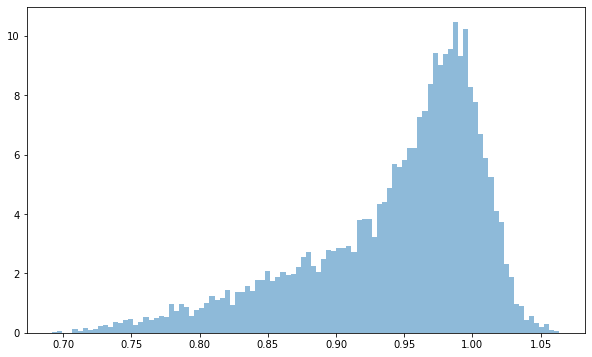

In [5]:
plt.figure(figsize=(10, 6))

plt.hist(M_irrs, bins=100, density=True, alpha=0.5)

plt.show()

### Thumb rules distribution: 

I choose to use the $\textbf{"Freedman-Diaconis rule"}$: 
    
$\Delta_{b} = \frac{2 (q_{75} - q_{25})}{N^{1/3}} = \frac{2.7 \sigma_{G}}{N^{1/3}}$
    
To apply the formula I first evaluate $\sigma_{G}$: 

In [6]:
from astroML import stats as astroMLstats  # this module is useful to evaluate it fast

sigmaG2 = astroMLstats.sigmaG(M_irrs)

In [7]:
# use the formula and get the bins size

binsize = 2.7 * sigmaG2 / (N ** (1 / 3))
binsG = np.append(np.arange(start=M_irrs.min(), stop=M_irrs.max(), step=binsize) , M_irrs.max()) 

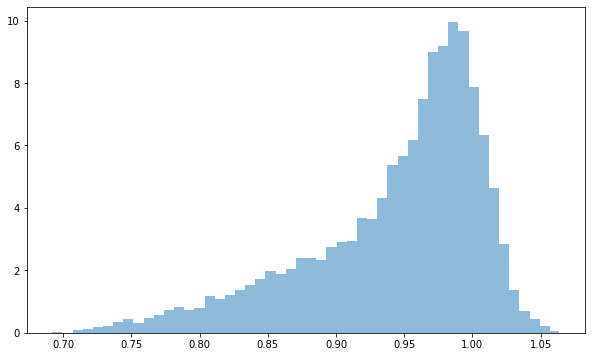

In [8]:
plt.figure(figsize=(10, 6))

plt.hist(M_irrs, bins=binsG, density=True, alpha=0.5)

plt.show()

### KDE distribution: 

In [9]:
from sklearn.neighbors import KernelDensity

x_i = np.linspace(M_irrs.min(),M_irrs.max(), 10000)  # prepare the x_i array to plot the distribution

Now I define the function that returns the distribution, according to the KDE: 

In [10]:
def kde_sklearn(data, c_bandwidth, c_kernel):
    
    kde_skl = KernelDensity(bandwidth = c_bandwidth, kernel = c_kernel)
    
    kde_skl.fit(data[:, np.newaxis])
    
    log_pdf = kde_skl.score_samples(x_i[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

Folowing the steps of Lec.7, I start by plotting the distributions: 

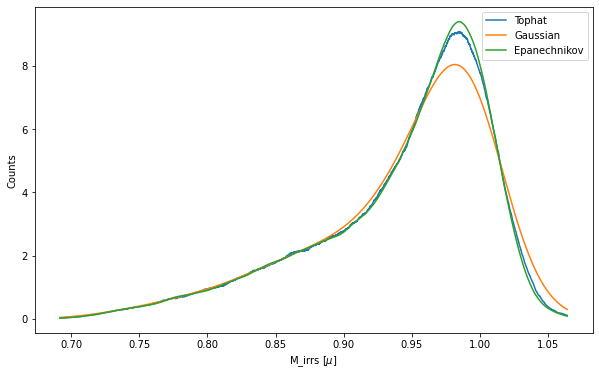

In [11]:
pdf_TH = kde_sklearn(M_irrs, 0.02, "tophat")
pdf_G = kde_sklearn(M_irrs, 0.02, "gaussian")
pdf_E = kde_sklearn(M_irrs, 0.02, "epanechnikov")

plt.figure(figsize=(10, 6))
plt.plot(x_i, pdf_TH, label="Tophat")
plt.plot(x_i, pdf_G, label="Gaussian")
plt.plot(x_i, pdf_E, label="Epanechnikov")

plt.xlabel("M_irrs [$\mu$]")
plt.ylabel("Counts")
plt.legend();

### KS distance:

First define f: 

In [12]:
def f(M_irrs, M): 
    
    return M_irrs / M

Then set the values for the $\sigma$: 

In [13]:
sigma = np.logspace(-3, 2, 100)

Produce the $M$, $\chi$, $M_{irr}$ and $f$ distributions: 

In [14]:
Ms = np.array([norm.rvs(1, s, len(sigma)) for s in sigma])
chis = np.array(uniform.rvs(0, 1, len(sigma)))

In [15]:
M_irrs_1 = M_irr(chis, Ms)
fs = f(M_irrs_1, Ms)

Now I evaluate the KS distance:

In [16]:
from scipy.stats import ks_2samp, kstest

Null hypotheses: 

- $\textbf{$M_{irr}$ VS f}: M_{irr}$ follows f distribution
- $\textbf{$M_{irr}$ VS M}: M_{irr}$ follows M distribution



In [17]:
p_vals_fVSMirr = np.array([kstest(M_irrs_1[i], fs[i], "two-sided")[1] for i in range(0, len(fs))]) 
p_vals_MVSMirr = np.array([kstest(M_irrs_1[i], Ms[i], "two-sided")[1] for i in range(0, len(fs))])

I here report some plots: 

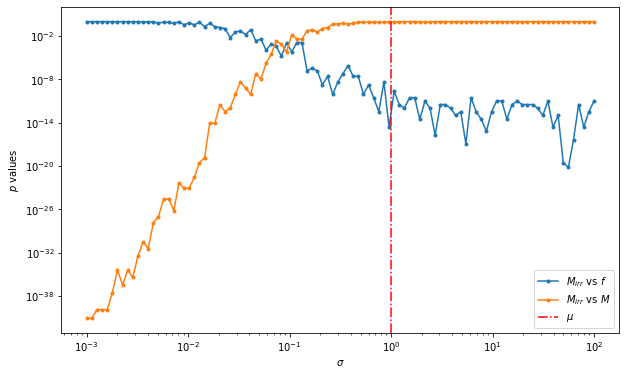

In [18]:
plt.figure(figsize=(10, 6))
plt.loglog(sigma, p_vals_fVSMirr, label="$M_{irr}$ vs $f$", marker='.')
plt.loglog(sigma, p_vals_MVSMirr, label="$M_{irr}$ vs $M$", marker='.')
plt.axvline(x = 1, linestyle = '-.', c = 'r', label = "$\mu$")
plt.xlabel("$\sigma$")
plt.ylabel("$p$ values")
plt.legend();

Statement: I wish to test the null hypothesis that a sample is distributed
according to the $f$ or $M$ distribution. 

The above plot has two behaviours: 

- on the left we observe that the $p$-value has bigger values for the $\mathrm{f \ vs \ } M_{irr}$ KS. 
- on the right we observe the opposite ($p$-value has bigger values for the $\mathrm{M \ vs \ } M_{irr}$ KS). 

This means that one has a bigger probability to reject the hypothesis that $M_{irr}$ is distributed like $M$ $\textbf{IF}$ $\sigma\ll \mu$. Else, one has a bigger probability to reject the hypothesis that $M_{irr}$ is distributed like $f$ $\textbf{IF}$ $\sigma\gg \mu$.

In [19]:
# (Se prendo un sample dalla prima quale è la probabilità che sia distribuito come la SECONDA)

### Check with the analitic distribution: 

\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}

First I set the values for $f$ ($M_{irr}$ will be the x_i array I set before): 

In [20]:
fs_int = np.linspace(1/np.sqrt(2), 0.999999, 10000)

Define the function I have to integrate: 

In [21]:
def func(M_irr, f, mu, sigma): 
    
    return np.exp(- ((M_irr/f - mu)**2 / (2 * sigma**2))) * (2 * f**2 - 1) / (f * np.sqrt(1 - f**2))

Set an array of results for the integral, varying the $M_{irr}$ value each time: 

In [22]:
integrals = np.sqrt(2 / np.pi) / 0.02 * np.array([np.trapz(func(x, fs_int, 1, 0.02), dx=fs_int[1] - fs_int[0]) for x in x_i])

Plotting the distribution and the result of the integration I carried out: 

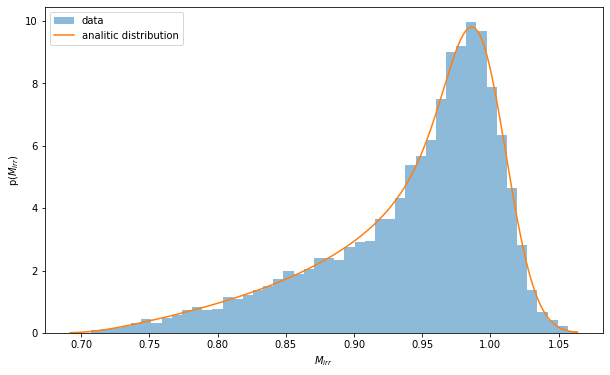

In [23]:
plt.figure(figsize=(10, 6))

plt.hist(M_irrs, bins=binsG, density=True, alpha=0.5, label="data")
plt.plot(x_i, integrals, label="analitic distribution");

plt.xlabel("$M_{irr}$")
plt.ylabel("p($M_{irr}$)")
plt.legend();

plt.show()